In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import muon as mu

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [3]:
mdata = mu.read("/Users/jerryaaaaaa/tcr_model.h5mu")

/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Drop cells with NA clonal_dynamic_label

In [9]:
valid_cells = mdata["airr"].obs[~mdata["airr"].obs["clonal_dynamic_label"].isna()].index
mdata_filtered = mdata[valid_cells].copy()
mdata_filtered["gex"].obs["clonal_dynamic_label"] = mdata_filtered["airr"].obs["clonal_dynamic_label"]
mdata_filtered["gex"].obs["clonal_dynamic"] = mdata_filtered["airr"].obs["clonal_dynamic"]
mdata_filtered["gex"].obs["clone_id"] = mdata_filtered["airr"].obs["clone_id"]

Generating leiden clustering derived reactivity proxy label

In [10]:
mdata_filtered["gex"].obs["phenotype_label"] = mdata_filtered["gex"].obs["leiden"].map({
    "2": "Reactive",
    "0": "Nonreactive",
    "1": "Nonreactive",
    "3": "Nonreactive",
    "4": "Nonreactive",
    "5": "Nonreactive",
})
clonal_reactivity = (
    mdata_filtered["gex"].obs.groupby("clone_id")["phenotype_label"]
    .agg(lambda x: "Reactive" if "Reactive" in x.values else "Nonreactive")
)
mdata_filtered["gex"].obs["proxy_label"] = (
    mdata_filtered["gex"].obs["clone_id"].map(clonal_reactivity)
)

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_52777/3651444620.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdata_filtered["gex"].obs.groupby("clone_id")["phenotype_label"]


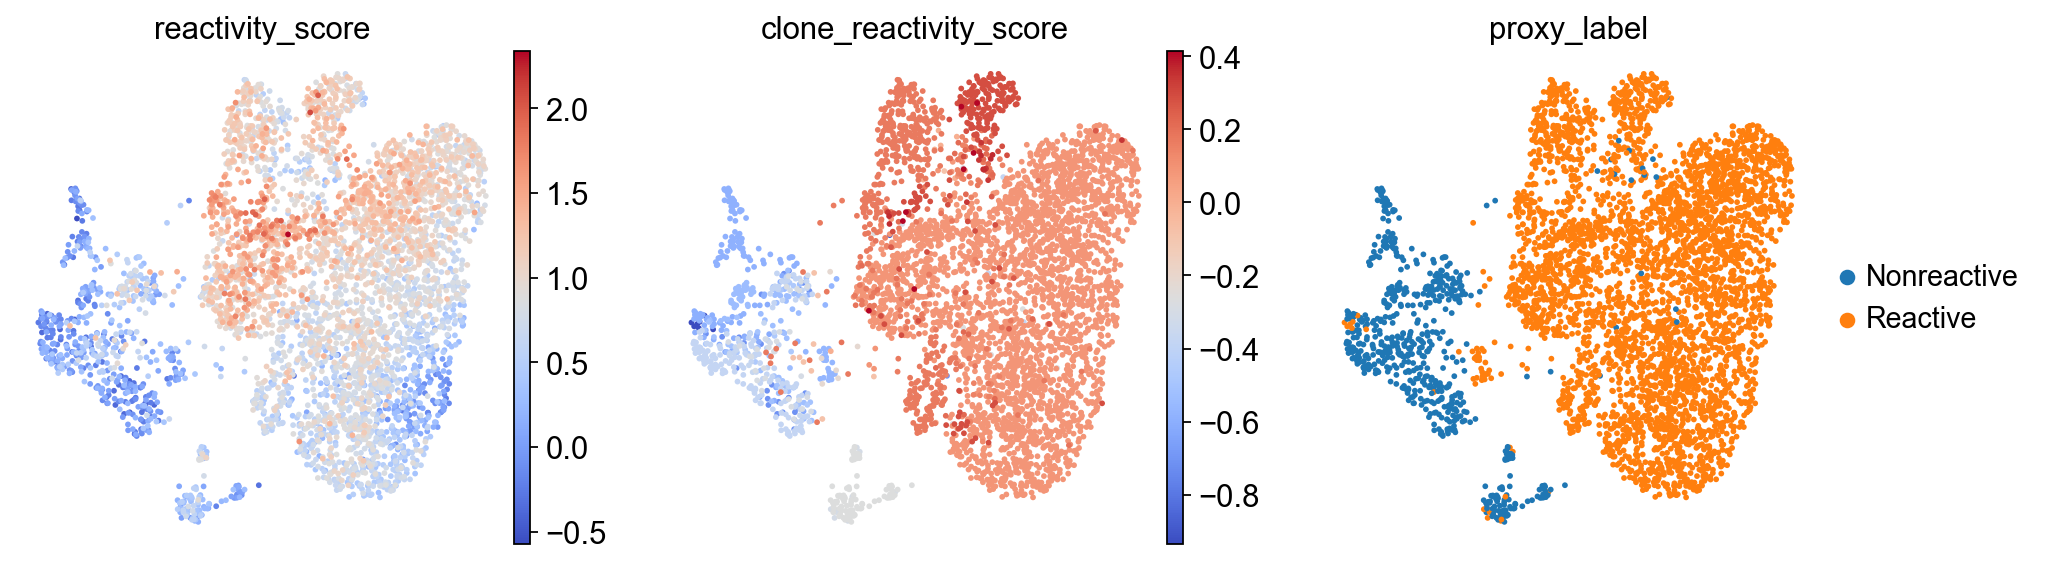

In [57]:
sc.pl.umap(mdata_filtered["gex"], color=["reactivity_score", "clone_reactivity_score", "proxy_label"], cmap="coolwarm", frameon=False)

DEGs (Reactive vs Nonreactive)

In [12]:
sc.tl.rank_genes_groups(mdata_filtered["gex"], groupby="proxy_label", method="wilcoxon")

ranking genes


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [ ]:
deg_df = sc.get.rank_genes_groups_df(mdata_filtered["gex"], group="Reactive")
deg_df_filtered = deg_df[
    (deg_df["pvals_adj"] < 0.05) &
    (deg_df["logfoldchanges"].abs() > 0.25)
    ]
feature_genes = deg_df_filtered["names"].unique().tolist()

In [14]:
len(feature_genes)

2424

In [16]:
X_genes = mdata_filtered["gex"][:, feature_genes].to_df()
X_other = mdata_filtered["gex"].obs[[
    "alpha_cdr3_len",
    "beta_cdr3_len",
    "clonal_dynamic_label",
    "expansion_fold"
]]
X = pd.concat([X_genes, X_other], axis=1)
y = mdata_filtered["gex"].obs["clone_reactivity_score"]

Train/Test split for at the clonal level

In [17]:
clone_scores = mdata_filtered["gex"].obs[["clone_id", "clone_reactivity_score"]].drop_duplicates()

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
#Train/test split at the clone level
train_clones, test_clones = train_test_split(
    clone_scores["clone_id"], test_size=0.3, random_state=42
)
#Assign cells to train/test based clone_id
train_cells = mdata_filtered["gex"].obs[mdata_filtered["gex"].obs["clone_id"].isin(train_clones)].index
test_cells = mdata_filtered["gex"].obs[mdata_filtered["gex"].obs["clone_id"].isin(test_clones)].index

In [20]:
X_train = X.loc[train_cells]
X_test = X.loc[test_cells]
y_train = y.loc[train_cells]
y_test = y.loc[test_cells]

Train/Test split at per cell level

In [40]:
cells_ids = mdata_filtered.obs_names

train_cells, test_cells = train_test_split(
    cells_ids,
    test_size=0.3,
    random_state=42
)
mdata_train = mdata_filtered[train_cells].copy()
mdata_test = mdata_filtered[test_cells].copy()

In [41]:
gex_train = mdata_train["gex"].to_df()[feature_genes]
gex_test = mdata_test["gex"].to_df()[feature_genes]

tcr_train = mdata_train["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label", "expansion_fold"]]
tcr_test = mdata_test["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label", "expansion_fold"]]

In [42]:
X_train = pd.concat([gex_train, tcr_train], axis=1)
X_test = pd.concat([gex_test, tcr_test], axis=1)

y_train = mdata_train["gex"].obs["reactivity_score"]
y_test = mdata_test["gex"].obs["reactivity_score"]

Regression Model (XGBoost Regressor) Trained with per cell reactivity score

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

In [22]:
xgb_reg = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

In [43]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [44]:
y_pred = xgb_reg.predict(X_test)

In [45]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.0115
R^2 Score: 0.9399


Text(0, 0.5, 'Predicted Score')

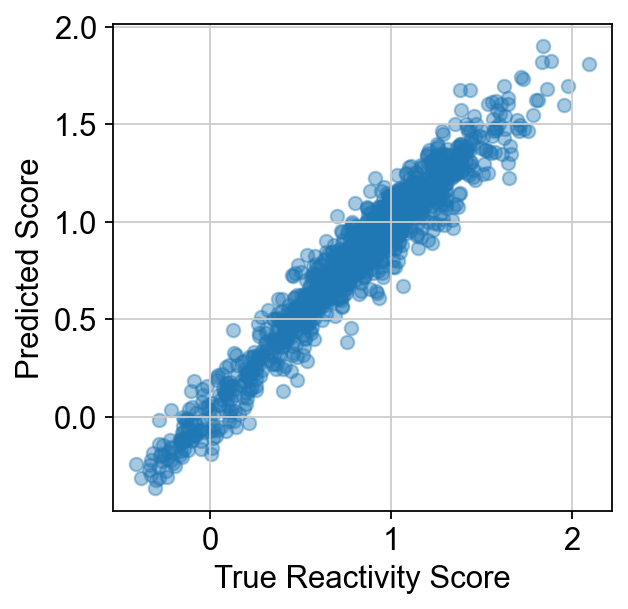

In [84]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("True Reactivity Score")
plt.ylabel("Predicted Score")

Feature importance

In [47]:
from xgboost import plot_importance

In [48]:
importance_dict = xgb_reg.get_booster().get_score(importance_type="weight")

importance_df = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
})
importance_df = importance_df.sort_values(by="importance", ascending=False)

In [53]:
import seaborn as sns

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_52777/3444438936.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), y="feature", x="importance", palette="magma")


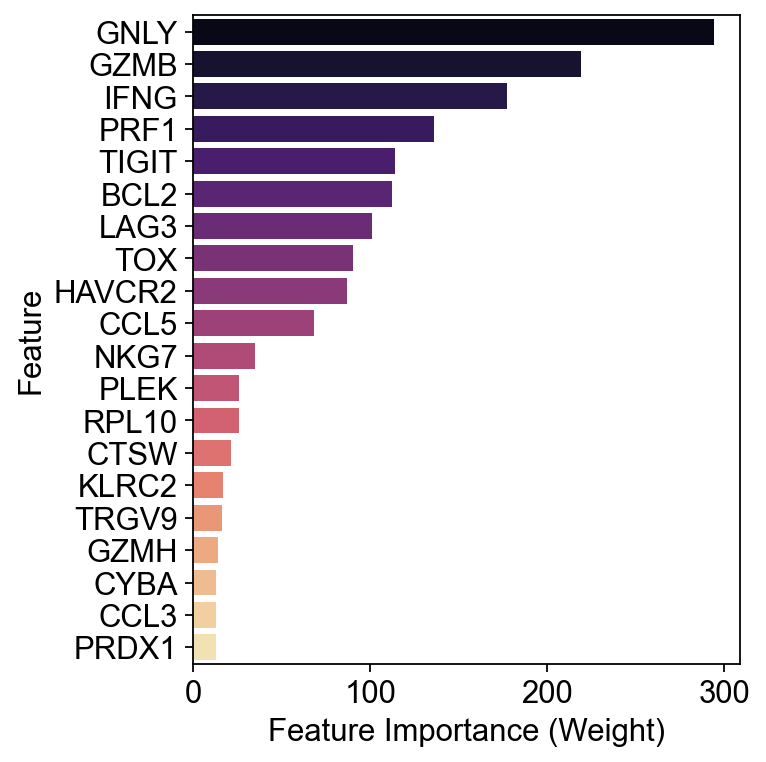

In [55]:
plt.figure(figsize=(5, 5))
sns.barplot(data=importance_df.head(20), y="feature", x="importance", palette="magma")

plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Feature")
plt.grid(False)
plt.tight_layout()
plt.show()

Predicted vs True reactivity score (UMAP)

In [77]:
mdata_test["gex"].obs.loc[y_test.index, "predicted_score"] = y_pred

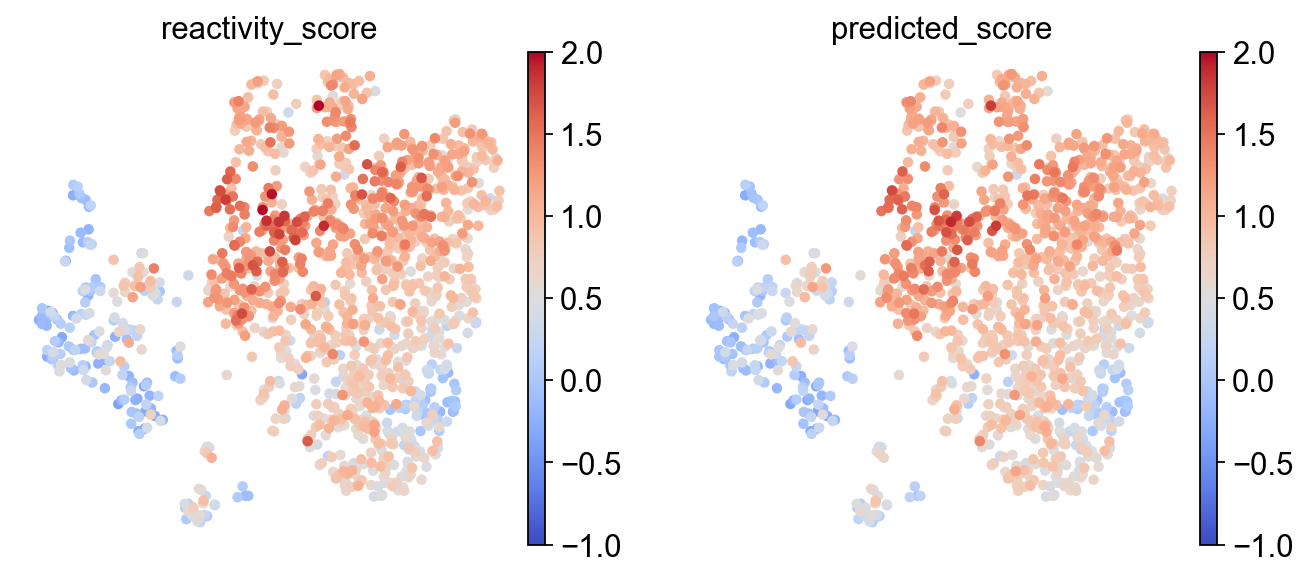

In [82]:
sc.pl.umap(mdata_test["gex"], color=["reactivity_score", "predicted_score"], cmap="coolwarm", frameon=False, vmax=2, vmin=-1)

In [91]:
mdata_test["gex"].obs["predicted_label"] = (mdata_test["gex"].obs["predicted_score"] > 0.5).map({
    True: "Reactive",
    False: "Nonreactive"
})

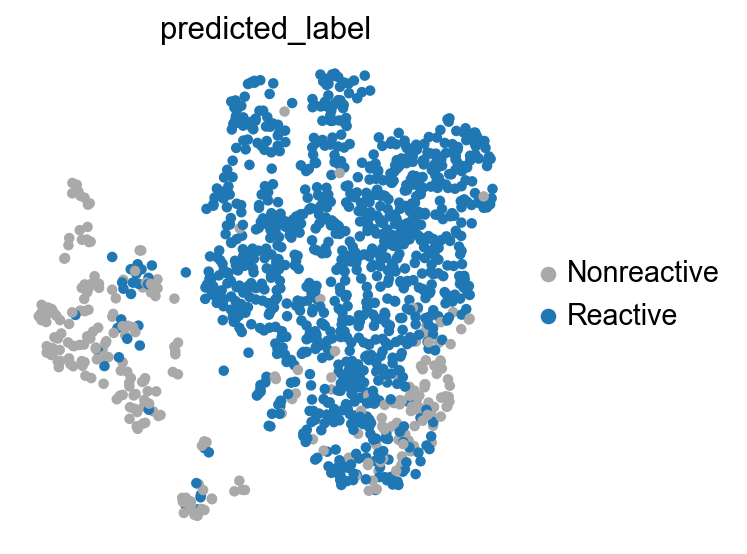

In [96]:
sc.pl.umap(mdata_test["gex"], color="predicted_label", frameon=False, palette=["darkgrey", "tab:blue"])

Model Prediction on full dataset

In [98]:
full_gex = mdata_filtered["gex"].to_df()[feature_genes]
full_tcr = mdata_filtered["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label", "expansion_fold"]]
full_X = pd.concat([full_gex, full_tcr], axis=1)

In [99]:
pred_score = xgb_reg.predict(full_X)

In [100]:
mdata_filtered["gex"].obs["predicted_score"] = pred_score

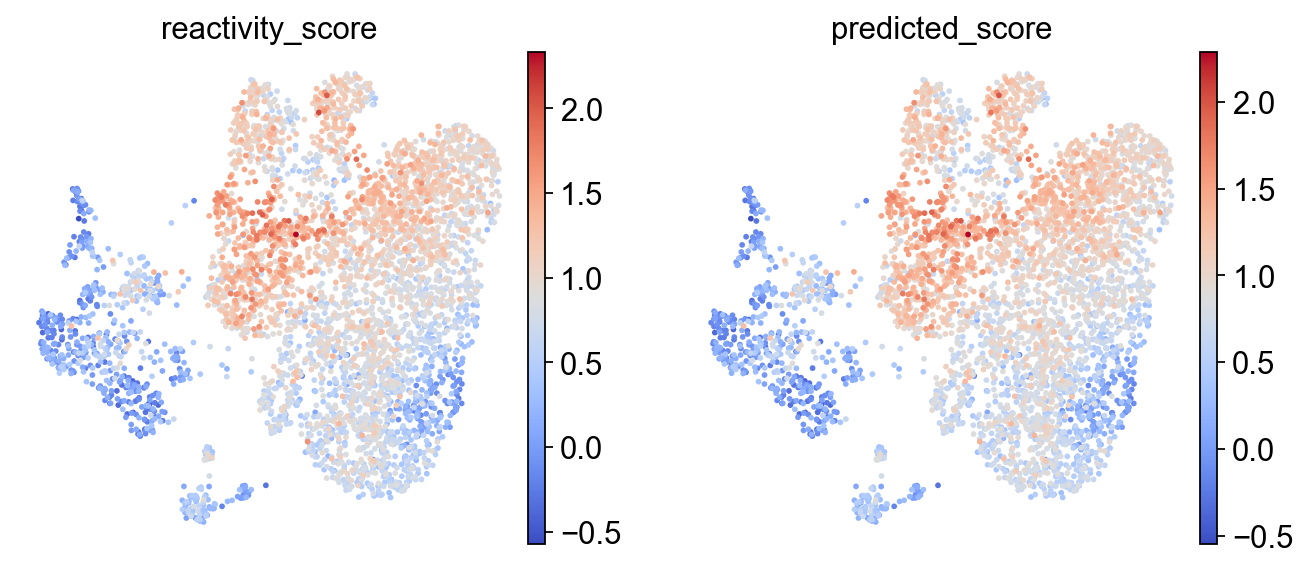

In [101]:
sc.pl.umap(mdata_filtered["gex"], color=["reactivity_score", "predicted_score"], cmap="coolwarm", frameon=False)

Classification Model (Based on regression_predicted reactivity score)

Reactive: predicted_score > 1 else: Nonreactive

In [105]:
mdata_filtered["gex"].obs["predicted_label"] = (pred_score > 1).astype(int)

In [108]:
features = full_X.copy()
labels = mdata_filtered["gex"].obs["predicted_label"]

In [109]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels
)

In [111]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Consider class imbalance

In [112]:
#Compute class ratio
ratio = (y_train_class == 0).sum() / (y_train_class == 1).sum()

In [113]:
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42
)

In [114]:
xgb_clf.fit(X_train_class, y_train_class)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [115]:
y_clf_pred = xgb_clf.predict(X_test_class)
y_clf_proba = xgb_clf.predict_proba(X_test_class)[:, 1]

In [116]:
print("ROC_AUC:", roc_auc_score(y_test_class, y_clf_proba))

ROC_AUC: 0.979618336540914


Model performance evaluation/ROC_AUC

In [117]:
from sklearn.metrics import roc_curve

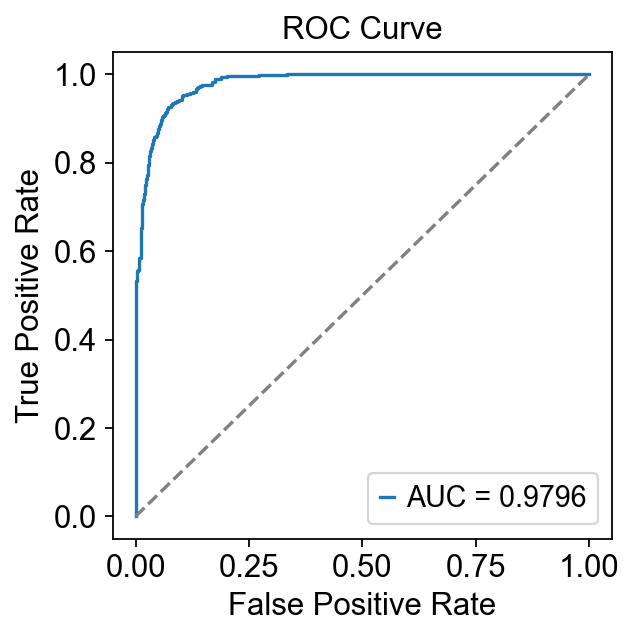

In [118]:
fpr, tpr, thresholds = roc_curve(y_test_class, y_clf_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_class, y_clf_proba):.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

Model performance evaluation/Precision & Recall

In [119]:
from sklearn.metrics import precision_recall_curve, average_precision_score

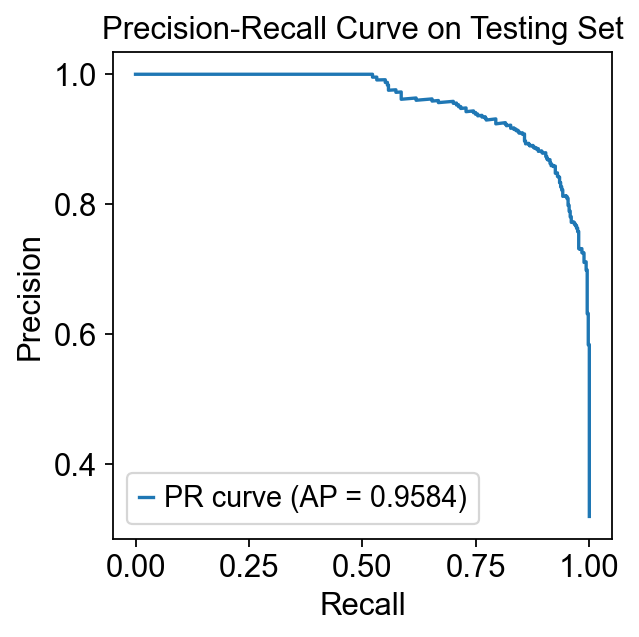

In [122]:
precision, recall, thresholds = precision_recall_curve(y_test_class, y_clf_proba)
ap = average_precision_score(y_test_class, y_clf_proba)

plt.plot(recall, precision, label=f"PR curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Testing Set")
plt.legend()
plt.grid(False)
plt.show()

In [123]:
from sklearn.model_selection import cross_val_score

In [124]:
scores = cross_val_score(xgb_clf, X_train_class, y_train_class, cv=5, scoring="roc_auc")
print("Cross-validated AUCs:", scores)
print("Mean AUC:", np.mean(scores))

Cross-validated AUCs: [0.98060142 0.9810967  0.97946098 0.97284773 0.97991135]
Mean AUC: 0.9787836351569166


Classfication model prediction on total mdata

In [140]:
y_total_proba = xgb_clf.predict_proba(features)[:, 1]

In [141]:
mdata_filtered["gex"].obs["predicted_reactivity_proba"] = y_total_proba

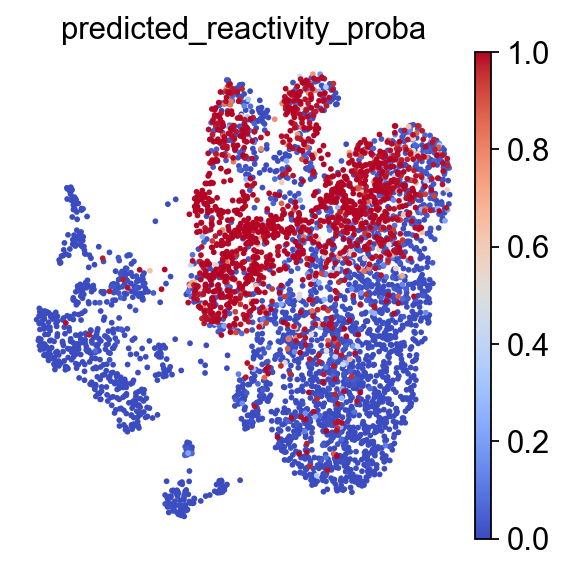

In [143]:
sc.pl.umap(mdata_filtered["gex"], color="predicted_reactivity_proba", cmap="coolwarm", frameon=False, vmax=1, vmin=0)

In [144]:
xgb_predict_df = pd.DataFrame({
    "clone_id": mdata_filtered["gex"].obs["clone_id"],
    "reactivity_proba": y_total_proba
})
clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_52777/3290524566.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()


In [145]:
clone_reactivity

clone_id
0      0.349761
1      0.613144
2      0.442875
3      0.019032
4      0.002420
5      0.016537
6      0.013716
8      0.027659
9      0.000638
12     0.002688
14     0.001309
16     0.366792
18     0.541277
19     0.000721
21     0.415938
22     0.468509
23     0.295738
26     0.068517
27     0.001578
29     0.006556
30     0.000650
31     0.369299
37     0.305073
40     0.628837
41     0.284214
42     0.166694
51     0.002618
53     0.225454
54     0.001025
56     0.615629
58     0.628824
60     0.336790
63     0.489860
72     0.145007
76     0.000859
77     0.438077
89     0.166768
91     0.001221
94     0.427129
100    0.198577
111    0.002613
170    0.006875
Name: reactivity_proba, dtype: float32

Adding enrichment tier to meta mdata

In [63]:
tcr_clonal_info = pd.read_csv("/Users/jerryaaaaaa/clonal_dynamic.csv")

In [64]:
tcr_clonal_info["clone_id"] = tcr_clonal_info["clone_id"].astype(str)
tcr_clonal_info = tcr_clonal_info.set_index("clone_id")
mdata["airr"].obs["enriched_tier"] = mdata["airr"].obs["clone_id"].map(tcr_clonal_info["enriched_tier"])
mdata["gex"].obs["enriched_tier"] = mdata["airr"].obs["enriched_tier"]


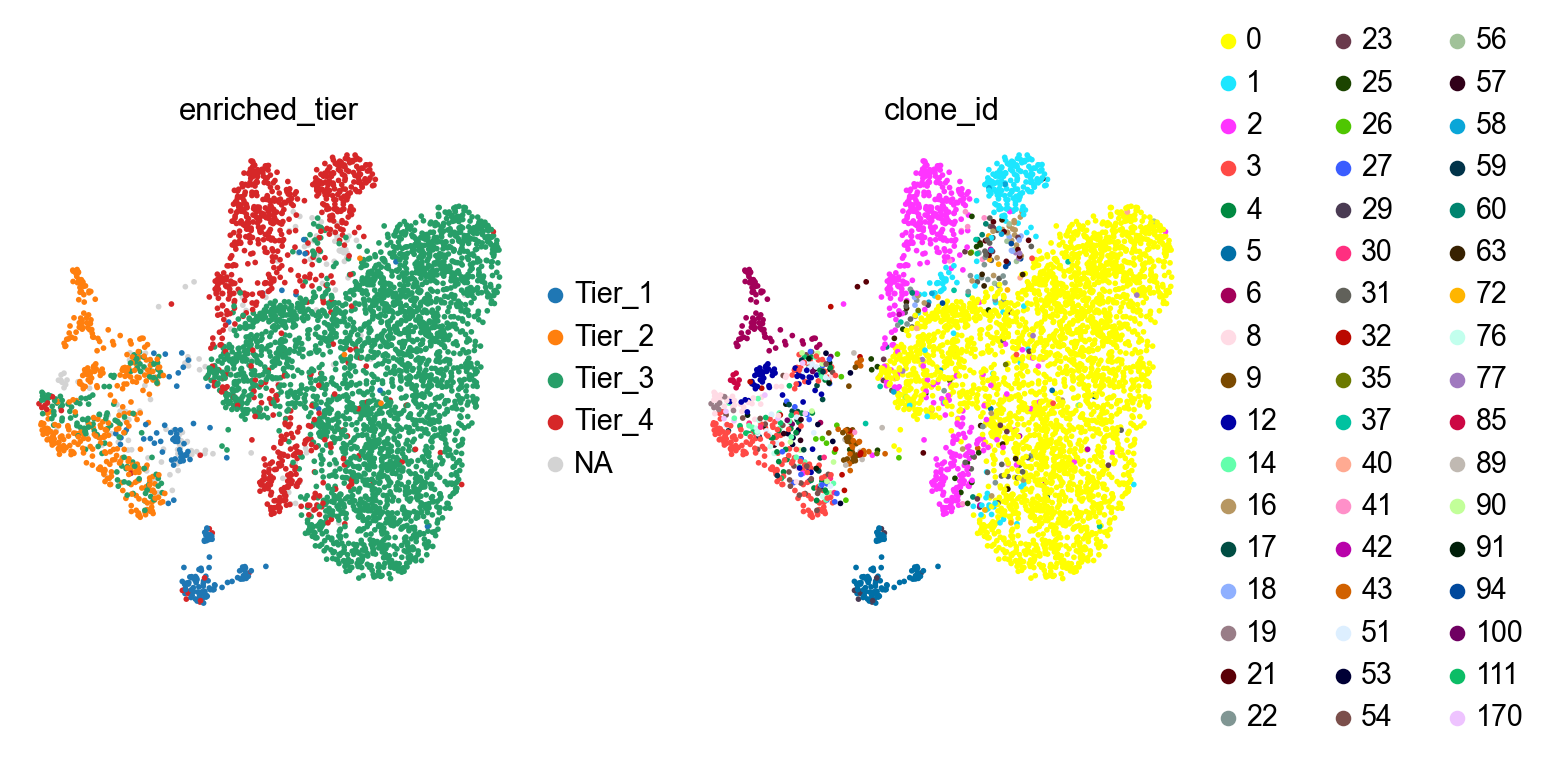

In [71]:
sc.pl.umap(mdata["gex"], color=["enriched_tier", "clone_id"], frameon=False)

In [72]:
mdata.write("/Users/jerryaaaaaa/tcr_model.h5mu")

In [135]:
deg_df_filtered.to_csv("/Users/jerryaaaaaa/deg_proxy.csv")